# Constitution of a corpus of NLP papers from two sources: ACL Anthology and ArXiv

**In this Notebook**: We will create two `Corpus` objects and populate them with `Paper`(s), whose content will be further investigated. We use two sources of papers (XML format) and metadata: [the ACL Anthology](#a-acl-corpus) and [ArXiv](#b-arxiv-corpus).

In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import json
from typing import Tuple, List
import pickle
import re
import tqdm
import os
from matplotlib import pyplot as plt
from collections import Counter
import sys
sys.path.insert(0, '../') # add parent directory (containing the util module) to path
import utils.Corpus

## A. ACL corpus

### 1. Initial data inspection

Data source: [ACL Anthology corpus](https://github.com/shauryr/ACL-anthology-corpus) by Shaurya Rohatgi (metadata + grobid extractions as XML files).

In [2]:
XML_FILES_DIR = "../data/acl/tei.xml/"
METADATA_PATH = "../data/acl/acl-publication-info.74k.v3.full-sections-partial-topic-labels.pkl"

Have a look at the complete metadata provided in Shaurya Rohatgi's corpus:

In [3]:
df = pd.read_pickle(METADATA_PATH)
print(df.shape)
df.columns

(73285, 26)


Index(['acl_id', 'abstract', 'full_text', 'corpus_paper_id', 'pdf_hash',
       'numcitedby', 'url', 'publisher', 'address', 'year', 'month',
       'booktitle', 'author', 'title', 'pages', 'doi', 'number', 'volume',
       'journal', 'editor', 'isbn', 'ENTRYTYPE', 'ID', 'language', 'note',
       'Model Predicted Topics'],
      dtype='object')

Check the years:

In [4]:
df["year"] = df["year"].astype(int)
df["year"].describe()

count    73285.000000
mean      2011.292707
std          9.885551
min       1952.000000
25%       2007.000000
50%       2014.000000
75%       2019.000000
max       2022.000000
Name: year, dtype: float64

Also check that for every article mentionned in the metadata, we have the corresponding XML file stored.

In [5]:
# for every acl_id, check that the xml file exists
for acl_id in tqdm.tqdm(list(df["acl_id"])):
    path = f"{XML_FILES_DIR}/{acl_id}.tei.xml"
    if not os.path.exists(path):
        print(f"File {path} does not exist")
        break

100%|██████████| 73285/73285 [00:17<00:00, 4257.75it/s]


Check for attributes with missing values:

In [6]:
for col in df.columns:
    none_rows = df[df[col].isnull()].shape[0]
    if none_rows > 0:
        print(f"No {col}: {none_rows}")

No abstract: 5616
No full_text: 5830
No pdf_hash: 1209
No publisher: 10119
No address: 7192
No month: 7323
No booktitle: 2041
No author: 667
No pages: 13807
No doi: 43607
No number: 71811
No volume: 71445
No journal: 71248
No editor: 73272
No isbn: 71915
No language: 70265
No note: 73088
No Model Predicted Topics: 42254


We can directly exclude papers that are explicitly not in English, and posters (at least, papers whose id contains "poster"):

In [7]:
df["language"].value_counts()

language
French                 1453
English                1371
Chinese                 188
German                    6
Portuguese (Brazil)       2
Name: count, dtype: int64

In [8]:
len([id_ for id_ in list(df["acl_id"].values) if "poster" in id_])

266

In [9]:
# get rid of the non-english papers
df_c = df[(df["language"] == "English") | (df["language"].isnull())]
print(df_c.shape)

# get rid of the posters
for i, row in df_c.iterrows():
    if "poster" in df_c.loc[i, "acl_id"]:
        df_c.drop(i, inplace=True)

print(df_c.shape)

(71636, 26)


C:\Users\cleme\AppData\Local\Temp\ipykernel_21484\1074398178.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c.drop(i, inplace=True)
C:\Users\cleme\AppData\Local\Temp\ipykernel_21484\1074398178.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c.drop(i, inplace=True)
C:\Users\cleme\AppData\Local\Temp\ipykernel_21484\1074398178.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c.drop(i, inplace=True)
C:\Users\cleme\AppD

(71553, 26)


In [11]:
# # save in pickle format
# df_c.to_pickle("acl-metadata-full-en_no-p.pkl")

### 2. Create `Corpus` object and extract papers content

Below, we create a `Corpus` and provide it with the paths to find useful XML papers and metadata. When calling `load_papers`, we extract the content of all the XML files in the corpus to create some `Paper` objects.

In [2]:
# XML_FILES_DIR = "../data/acl/tei.xml/"
# METADATA_PATH = "../data/acl/acl-metadata-full-en_no-p.pkl"

# corpus_ACL = utils.Corpus.Corpus(xml_dir_path= XML_FILES_DIR,
#                     metadata_path = METADATA_PATH,
#                     name = "ACL")

In [3]:
# corpus_ACL.load_papers()

100%|██████████| 71553/71553 [9:35:20<00:00,  2.07it/s]   


Then, the method `preprocess_papers` will sort sentences from `Paper` objects into two categories: candidates (for containing claims) and non candidates, based on the section that they belong to (e.g the sentences of a section named "Experimental setup" will be considered as non candidates).

In [4]:
# corpus_ACL.preprocess_papers()

In [5]:
# # serialize the corpus for later access
# with open("../data/acl/corpus_ACL.pkl", "wb") as f:
#     pickle.dump(corpus_ACL, f)

In [2]:
with open("../data/acl/corpus_ACL.pkl", "rb") as f:
    corpus_ACL = pickle.load(f)

corpus_ACL

### 3. Corpus content inspection

#### Errors

All the encountered errors (e.g a `Paper` object couldn't be correctly initialized because the corresponding XML file is not well-structured) are stored for later analysis. Plus, the "correct" and "incorrect" `Paper` objets are stored separately into `Corpus` attributes `papers` and `papers_with_errors`.

In [3]:
print(len(corpus_ACL.papers))
print(len(corpus_ACL.papers_with_errors))

58180
13373


We can know more about these errors:

In [12]:
corpus_ACL.describe(error_verbose=True)

Corpus 'ACL' was filled with 71553 papers:
  - 58180 papers were successfully loaded
  - 13373 papers could not be loaded

Errors:
  - Parsing error: XML file not well formed : 5523
  - Parsing error: no abstract found : 3163
  - Noisy data: wrong language (sk) : 8
  - Noisy data: wrong language (sq) : 34
  - parsing error: not enough paper content found (<2 distinct sections) : 715
  - Noisy data: wrong language (da) : 155
  - Noisy data: wrong language (de) : 76
  - Noisy data: wrong language (fr) : 636
  - Noisy data: wrong language (sl) : 8
  - Noisy data: wrong language (hr) : 4
  - Noisy data: wrong language (so) : 21
  - Noisy data: wrong language (tr) : 11
  - Noisy data: wrong language (pl) : 21
  - Noisy data: wrong language (pt) : 124
  - Noisy data: wrong language (af) : 1
  - Noisy data: wrong language (et) : 3
  - Noisy data: wrong language (no) : 40
  - Noisy data: wrong language (nl) : 8
  - Noisy data: wrong language (vi) : 26
  - Noisy data: wrong language (es) : 10
 

In [13]:
# collect the encountered errors
errors = [[pe.id, pe.init_error, pe.title, pe.abstract, pe.year] for pe in corpus_ACL.papers_with_errors]
df_errors = pd.DataFrame(errors, columns=["id", "error", "title", "abstract", "year"])
df_errors.to_csv("../data/acl/acl-init-errors.csv", index=False)

In [15]:
df_errors = pd.read_csv("../data/acl/acl-init-errors.csv")
df_errors.groupby("error").count()

,id,title,abstract,year
error,,,,
Noisy data: wrong language (af),1,1,1,1
Noisy data: wrong language (bn),6,6,0,6
Noisy data: wrong language (cs),5,5,1,5
Noisy data: wrong language (da),155,155,12,155
Noisy data: wrong language (de),76,76,7,76
Noisy data: wrong language (es),10,10,4,10
Noisy data: wrong language (et),3,3,3,3
Noisy data: wrong language (fi),12,12,12,12
Noisy data: wrong language (fr),636,636,584,636


In [17]:
df_errors[df_errors["error"].str.startswith("Noisy data: wrong language")].shape

(1427, 5)

In [26]:
# plot a graph for all the different types of languages contained in the corpus
import re
df_errors_lg = df_errors[df_errors["error"].str.startswith("Noisy data: wrong language")]
df_errors_lg["lg"] = df_errors_lg["error"].apply(lambda x: re.match(re.compile("Noisy data: wrong language (\(.*\))"), x).group(1).strip("()"))
df_errors_lg

C:\Users\cleme\AppData\Local\Temp\ipykernel_21484\1734814697.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_errors_lg["lg"] = df_errors_lg["error"].apply(lambda x: re.match(re.compile("Noisy data: wrong language (\(.*\))"), x).group(1).strip("()"))


,id,error,title,abstract,year,lg
11,W02-1409,Noisy data: wrong language (sk),An {LCS}-Based Approach for Analyzing {J}apane...,Hr q sr g &g h i 5j k ml on qp &j r es p at uk...,2002,sk
17,N01-1004,Noisy data: wrong language (sq),Why Inverse Document Frequency?,NaN,2001,sq
47,C02-1165,Noisy data: wrong language (da),Complexity of Event Structure in {IE} Scenarios,NaN,2002,da
49,2012.iwslt-evaluation.16,Noisy data: wrong language (de),The {NICT} translation system for {IWSLT} 2012,NaN,2012,de
51,C00-2136,Noisy data: wrong language (da),Automatic Acquisition of Domain Knowledge for ...,NaN,2000,da
...,...,...,...,...,...,...
10791,W04-0864,Noisy data: wrong language (so),Some experiments with a Naive {B}ayes {WSD} sy...,NaN,2004,so
10792,W04-1512,Noisy data: wrong language (sq),Dependencies as Categories,NaN,2004,sq
10806,P00-1069,Noisy data: wrong language (da),Word Sense Disambiguation by Learning from Unl...,NaN,2000,da
10820,P04-3009,Noisy data: wrong language (da),Wide Coverage Symbolic Surface Realization,NaN,2004,da


In [42]:
from matplotlib import pyplot as plt

counts = df_errors_lg.groupby("lg").count().sort_values("id", ascending=False)
counts

,id,error,title,abstract,year
lg,,,,,
fr,636,636,636,584,636
da,155,155,155,12,155
zh-tw,148,148,148,6,148
pt,124,124,124,75,124
de,76,76,76,7,76
no,40,40,40,6,40
sv,38,38,38,11,38
sq,34,34,34,9,34
vi,26,26,26,7,26


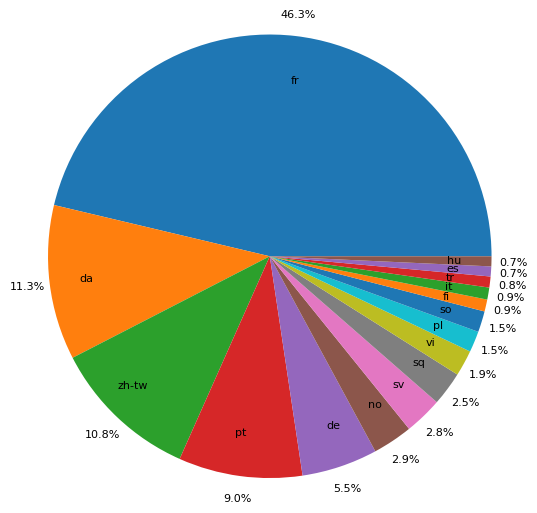

In [59]:
# plot a pie chart to show the repartition of languages in the corpus
languages = [lg for lg in list(counts.index) if counts.loc[lg, "id"] >= 10]
values = [count for count in list(counts.id) if count >=10]

# Label distance: gives the space between labels and the center of the pie
plt.pie(values, labels=languages, labeldistance=.8, autopct='%1.1f%%',
       pctdistance=1.1, textprops = {"fontsize": 8}, rotatelabels = False, radius = 1.5)
plt.show()

#### `Paper` objects

In [89]:
# an example of a Paper object
p = corpus_ACL.papers[123]

# some metadata
print(p.id)
print(p.title)
print(p.abstract)
print(p.year)

S07-1055
{OE}: {WSD} Using Optimal Ensembling ({OE}) Method
Optimal ensembling (OE) is a word sense disambiguation (WSD) method using word-specific training factors (average positive vs negative training per sense, posex and negex) to predict best system (classifier algorithm / applicable feature set) for given target word. Our official entry (OE1) in Senseval-4 Task 17 (coarse-grained English lexical sample task) contained many design flaws and thus failed to show the whole potential of the method, finishing -4.9% behind top system (+0.5 gain over best base system). A fixed system (OE2) finished only -3.4% behind (+2.0% net gain). All our systems were 'closed', i.e. used the official training data only (average 56 training examples per each sense). We also show that the official evaluation measure tends to favor systems that do well with high-trained words.
2007


In [90]:
# the Corpus to which the Paper belongs
print(p.corpus)
print(p.corpus.name)

ACL


In [91]:
# the authors of the paper
print(p.authors)
for auth in p.authors:
    print(auth.names, auth.norm_names)

['Saarikoski', 'Harri M. T.'] ['Saarikoski', 'Harri M. T.']


More importantly, we have access to the content of the Paper:

In [92]:
p.content

,id,sentence,section,candidate
0,0,Optimal ensembling (OE) is a word sense disamb...,abstract,True
1,1,Our official entry (OE1) in Senseval-4 Task 17...,abstract,True
2,2,A fixed system (OE2) finished only -3.4% behin...,abstract,True
3,3,"All our systems were 'closed', i.e. used the o...",abstract,True
4,4,We also show that the official evaluation meas...,abstract,True
...,...,...,...,...
74,74,"In other words, the official measure does not ...",Discussion,True
75,75,"Therefore, it can be said that the official me...",Discussion,True
76,76,Since OE is a generic method that can be appli...,Conclusion and Further Work,True
77,77,With remaining open questions resolved (optimi...,Conclusion and Further Work,True


We can separately look at the candidate sentences (potential claims) and the non candidate ones (those who belong to a section which should, a priori, not contain claims).

In [93]:
p.content[p.content["candidate"] == True]

,id,sentence,section,candidate
0,0,Optimal ensembling (OE) is a word sense disamb...,abstract,True
1,1,Our official entry (OE1) in Senseval-4 Task 17...,abstract,True
2,2,A fixed system (OE2) finished only -3.4% behin...,abstract,True
3,3,"All our systems were 'closed', i.e. used the o...",abstract,True
4,4,We also show that the official evaluation meas...,abstract,True
5,5,Optimal ensembling is a novel method for combi...,Introduction,True
6,6,The essential difference from other ensembling...,Introduction,True
7,7,The method is loosely based on findings of sys...,Introduction,True
8,8,We selected support vector machine (SVM) (Vapn...,Machine (Mach) Selection,True
9,9,This was mainly because of their attested stre...,Machine (Mach) Selection,True


In [94]:
p.content[p.content["candidate"] == False]

,id,sentence,section,candidate
12,12,We extracted three contextual feature sets fro...,Feature Set (Fset) Selection,False
13,13,"We also used three 'multifsets' (1g-2g, 1g-pos...",Feature Set (Fset) Selection,False
14,14,We designed and ran two systems: OE1 (official...,System Descriptions,False
15,15,Selection of c(omplexity) parameter for SVM wa...,System Descriptions,False
16,16,This is based on accounts by e.g. Vapnik (1995...,System Descriptions,False
17,17,We learned the best-system predictor model usi...,System Descriptions,False
18,18,For 70 words where two fsets performed within ...,System Descriptions,False
19,19,OE2 (unofficial):,System Descriptions,False
20,20,This system incorporated the following fixes t...,System Descriptions,False
21,21,"First, we significantly reduced the base syste...",System Descriptions,False


#### Some corpus Statistics

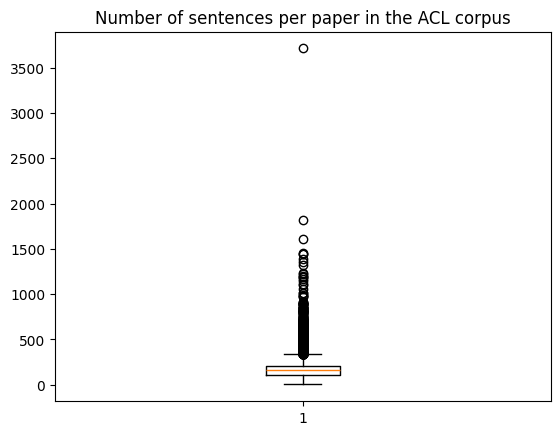

In [12]:
# boxplot of the number of sentences per paper in the corpus
sentences_per_paper = [len(p.content.sentence) for p in corpus_ACL.papers]
plt.boxplot(sentences_per_paper)
plt.title("Number of sentences per paper in the ACL corpus")
plt.show()

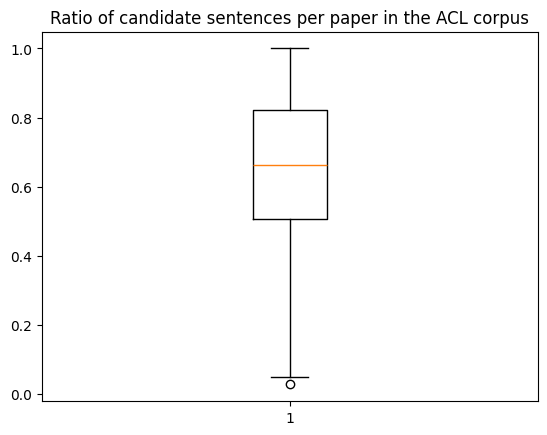

In [13]:
# boxplot of the ratio candidate sentences / total sentences per paper in the corpus
ratios = [p.content[p.content["candidate"] == True].shape[0] / len(p.content.sentence) for p in corpus_ACL.papers]
plt.boxplot(ratios)
plt.title("Ratio of candidate sentences per paper in the ACL corpus")
plt.show()

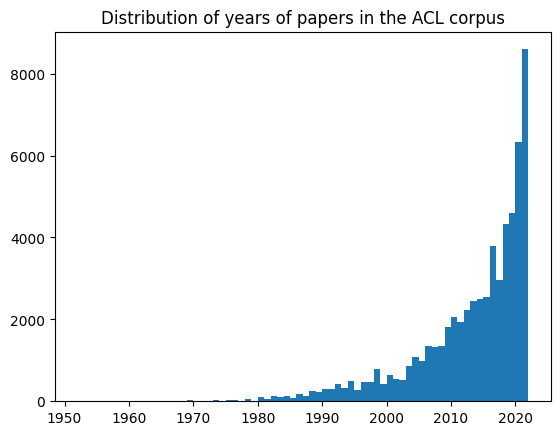

In [14]:
# distribution of years of the papers in the corpus
years = [int(p.year) for p in corpus_ACL.papers]
plt.hist(years, bins=range(min(years), max(years) + 1))
plt.title("Distribution of years of papers in the ACL corpus")
plt.show()

9401


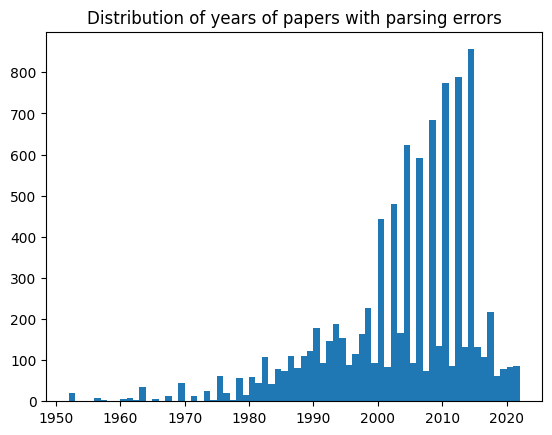

In [5]:
parsing_error_papers = [p for p in corpus_ACL.papers_with_errors if p.init_error.lower().startswith("parsing error")]
print(len(parsing_error_papers))

years = [int(p.year) for p in parsing_error_papers]
plt.hist(years, bins=range(min(years), max(years) + 1))
plt.title("Distribution of years of papers with parsing errors")
plt.show()

Now: draw a small sample as a toy corpus

In [7]:
# df_sample = df.sample(1000, random_state = 23)
# df_sample.to_pickle("../data/acl/acl-metadata-sample-1000.pkl")
# df = pd.read_pickle("../data/acl/acl-metadata-sample-1000.pkl")

## B. ArXiv corpus

### 1. Initial corpus inspection

We load the initial metadata of the entire ArXiv corpus, available on Kaggle.

In [11]:
data = []
with open("../data/arxiv/arxiv-metadata-oai-snapshot.json", "r", errors = "ignore", encoding = "utf-8") as f:
    for line in tqdm.tqdm(f):
        data.append(json.loads(line))

df = pd.DataFrame(data)

0it [00:00, ?it/s]

2445865it [01:50, 22097.29it/s]


In [12]:
print(df.shape)
df.head()

(2445865, 14)


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


We see that it is very large, but we will only keep the articles having the cs.CL category (Computational Linguistics), possibly among others.

In [13]:
df_NLP = df[df["categories"].str.contains("cs.CL")]
print(df_NLP.shape)

(59167, 14)


In [14]:
df_NLP.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
2082,0704.2083,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Introduction to Arabic Speech Recognition Usin...,"4 pages, 3 figures and 2 tables, was in Inform...",None,None,None,cs.CL cs.AI,None,In this paper Arabic was investigated from t...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[[Satori, H., ], [Harti, M., ], [Chenfour, N., ]]"
2200,0704.2201,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Arabic Speech Recognition System using CMU-Sph...,"5 pages, 3 figures and 2 tables, in French",None,None,None,cs.CL cs.AI,None,In this paper we present the creation of an ...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[[Satori, H., ], [Harti, M., ], [Chenfour, N., ]]"
3661,0704.3662,Tian-Jian Jiang,"Mike Tian-Jian Jiang, James Zhan, Jaimie Lin, ...",An Automated Evaluation Metric for Chinese Tex...,8 pages,"Jiang, Mike Tian-Jian, et al. ""Robustness anal...",None,None,cs.HC cs.CL,None,"In this paper, we propose an automated evalu...","[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2013-10-29,"[[Jiang, Mike Tian-Jian, ], [Zhan, James, ], [..."
3664,0704.3665,Tian-Jian Jiang,"Mike Tian-Jian Jiang, Deng Liu, Meng-Juei Hsie...",On the Development of Text Input Method - Less...,10 pages,None,None,None,cs.CL cs.HC,None,Intelligent Input Methods (IM) are essential...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[[Jiang, Mike Tian-Jian, ], [Liu, Deng, ], [Hs..."
3707,0704.3708,Bernat Corominas-Murtra BCM,Bernat Corominas-Murtra,Network statistics on early English Syntax: St...,"New abstract. Due to a mistake, abstract from ...",None,None,None,cs.CL,None,This paper includes a reflection on the role...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[[Corominas-Murtra, Bernat, ]]"


In [15]:
df_NLP.to_csv("../data/arxiv/arxiv-metadata-nlp.csv", index = False)
df_NLP = pd.read_csv("../data/arxiv/arxiv-metadata-nlp.csv")

In [65]:
# acronyms = ["ACL", "ANLP", "CL", "CoNLL", "EACL", "EMNLP", "IWSLT", "SemEval", "*SEM", "TACL", "WMT", "WS", "SIGANN", "SIGBIOMED", "SIGDAT", "SIGDIAL", "SIGEDU", "SIGEL", "SIGFSM", "SIGGEN", "SIGHAN", "SIGHUM", "SIGLEX", "SIGMEDIA", "SIGMOL", "SIGMORPHON", "SIGMT", "SIGNLL", "SIGPARSE", "SIGREP", "SIGSEM", "SIGSEMITIC", "SIMSLAV", "SIGSLPAT", "SIGSLT", "SIGTYP", "SIGUL", "SIGUR", "SIGWAC", "ALTA", "AMTA", "CCL", "COLING", "EAMT", "HLT", "IJCLCLP", "IJCNLP", "JEP", "TALN", "RECITAL", "KONVENS", "LILT", "LREC", "MTSummit", "MUC", "NEJLT", "PACLIC", "RANLP", "ROCLING", "TAL", "TINLAP", "TIPSTER"]
# df = pd.DataFrame(acronyms, columns = ["acronym"])
# df.to_csv("acl-anthology-events.csv", index = False)

In [18]:
# find the papers with a journal ref
published_NLP = df_NLP[~(df_NLP["journal-ref"].isnull()) | ~(df_NLP["doi"].isnull())]
print(published_NLP.shape)
published_NLP.head()["journal-ref"].values

(8310, 14)


array(['Jiang, Mike Tian-Jian, et al. "Robustness analysis of adaptive\n  chinese input methods." Advances in Text Input Methods (WTIM 2011) (2011): 53',
       'Computer Speech & Language 24(4): 698-710 (2010)',
       'Natural Language Engineering 10, 3-4 (09/2004) 211-225',
       'Dans Euralex 2000 Euralex 2000, Stuttgart : Allemagne (2000)',
       'PhD dissertation, May 1998, Department of Computer Science and\n  Engineering, Southern Methodist University'],
      dtype=object)

In [20]:
published_NLP.to_csv("../data/arxiv/arxiv-metadata-nlp-published.csv", index = False)

Then we remove papers having a journal ref or a DOI, indicating that they have been published.

In [19]:
unpublished_NLP = df_NLP[df_NLP["journal-ref"].isnull() & df_NLP["doi"].isnull()]
print(unpublished_NLP.shape)

(50857, 14)


In [21]:
unpublished_NLP.to_csv("../data/arxiv/arxiv-metadata-nlp-unpublished.csv", index = False)

In case the paper has been published after being first put in arXiv, and the authors haven't updated its information, we will check that the title of the paper is not already in the ACL Anthology.

In [22]:
# gather all (supposedly) unpublished titles from the arxiv NLP corpus
all_published_titles = []
for t in list(published_NLP["title"]):
    #t = utils.Author.Author.normalize_str(t).lower()
    nt = re.sub(re.compile('[^a-z]'), "", t.lower())
    all_published_titles.append((t, nt))

all_published_titles[0][1]

'anautomatedevaluationmetricforchinesetextentry'

In [23]:
# use the full acl anthology to gather all acl papers titles and authors
with open("C:/Users/cleme/Documents/STAGE/claims-in-NLP/data/acl/anthology.bib", "r", encoding="utf-8", errors = "ignore") as f:
    antho = str(f.read())

papers = [p.replace("\n", "") for p in antho.split("\n}\n")]
print(len(papers))
papers[14]

93387


'@inproceedings{zhu-etal-2024-resolving,    title = "Resolving Transcription Ambiguity in {S}panish: A Hybrid Acoustic-Lexical System for Punctuation Restoration",    author = "Zhu, Xiliang  and      Chang, Chia-Tien  and      Gardiner, Shayna  and      Rossouw, David  and      Robertson, Jonas",    editor = "Pyatkin, Valentina  and      Fried, Daniel  and      Stengel-Eskin, Elias  and      Stengel-Eskin, Elias  and      Liu, Alisa  and      Pezzelle, Sandro",    booktitle = "Proceedings of the Third Workshop on Understanding Implicit and Underspecified Language",    month = mar,    year = "2024",    address = "Malta",    publisher = "Association for Computational Linguistics",    url = "https://aclanthology.org/2024.unimplicit-1.3",    pages = "33--41",'

In [24]:
# example on one paper
tp = re.compile(r" title = \"(.*?)\",")
ap = re.compile(r" author = \"(.*?)\",")
lp = re.compile(r" url = \"(.*?)\",")

print(re.findall(tp, papers[14]))
print(re.findall(ap, papers[14]))
print(re.findall(lp, papers[14]))

['Resolving Transcription Ambiguity in {S}panish: A Hybrid Acoustic-Lexical System for Punctuation Restoration']
['Zhu, Xiliang  and      Chang, Chia-Tien  and      Gardiner, Shayna  and      Rossouw, David  and      Robertson, Jonas']
['https://aclanthology.org/2024.unimplicit-1.3']


In [25]:
# collect all the titles and authors of the papers in the anthology
import utils.Author
antho_papers = []

for p in papers:

    # catch the title
    t = re.findall(tp, p)
    if len(t) > 0:
        #t = utils.Author.Author.normalize_str(t[0]).lower()
        nt = re.sub(re.compile('[^a-z]'), "", t[0].lower())
    else:
        nt = ""

    # catch the authors
    authors = re.findall(ap, p)
    if len(authors) > 0:
        al = []
        als = authors[0].replace("\n", "").split(" and ")
        for a in als:
            names = a.split(",")
            ao = utils.Author.Author(names = [n.strip() for n in names])
            ao.normalize_names()
            al.append(ao)
    else:
        al = []

    # catch the url
    url = re.findall(lp, p)
    if len(url) > 0:
        u = url[0]
    else:
        u = ""

    antho_papers.append(((t, nt), al, u))

In [26]:
print(antho_papers[14][0])
print(antho_papers[14][1])
print(antho_papers[14][2])
print(antho_papers[14][1][0].norm_names)
print(antho_papers[14][1][1].norm_names)

(['Resolving Transcription Ambiguity in {S}panish: A Hybrid Acoustic-Lexical System for Punctuation Restoration'], 'resolvingtranscriptionambiguityinspanishahybridacousticlexicalsystemforpunctuationrestoration')
[<utils.Author.Author object at 0x000001CE73283D50>, <utils.Author.Author object at 0x000001CE73282C50>, <utils.Author.Author object at 0x000001CE73282510>, <utils.Author.Author object at 0x000001CE73280C10>, <utils.Author.Author object at 0x000001CE73281D10>]
https://aclanthology.org/2024.unimplicit-1.3
['Zhu', 'Xiliang']
['Chang', 'Chia-Tien']


Find the arxiv papers whose title is already found in the ACL Anthology:

In [27]:
all_ACL_titles = [t_and_a[0][1] for t_and_a in antho_papers]
inter = set([t[1] for t in all_published_titles]).intersection(set(all_ACL_titles))
print(len(inter))
list(inter)[0]

2265


'bilinguallexiconinductionwithsemisupervisioninnonisometricembeddingspaces'

In [82]:
import editdistance

remaining_arxiv_titles = [t[1] for t in all_unpublished_titles if t[1] not in inter]

for arxiv_title in tqdm.tqdm(remaining_arxiv_titles):
    for acl_title in list(all_ACL_titles):
        dist = editdistance.distance(arxiv_title, acl_title)
        if dist <= 5:
            print(acl_title, arxiv_title)

  2%|▏         | 57/3735 [01:22<1:20:25,  1.31s/it]

confidencemeasuresforstatisticalmachinetranslation newconfidencemeasuresforstatisticalmachinetranslation


  3%|▎         | 101/3735 [02:25<1:27:11,  1.44s/it]


KeyboardInterrupt: 

In [28]:
# remove from the arxiv NLP corpus the papers that are already in the intersection
published_NLP = published_NLP[~published_NLP["title"].str.lower().str.replace(re.compile('[^a-z]'), "", regex = True).isin(inter)]
print(published_NLP.shape)
# reset the index
published_NLP.reset_index(drop = True, inplace = True)

(6039, 14)


In [29]:
published_NLP.to_csv("../data/arxiv/arxiv-metadata-nlp-published.csv", index = False)

In [ ]:
unpublished_titles = [p.title for p in ar]
for i, row in published_NLP.iterrows():
    title = row["title"]
    if title in 

In [31]:
# gather all (supposedly) unpublished titles from the arxiv NLP corpus
all_unpublished_titles = []
for t in list(unpublished_NLP["title"]):
    #t = utils.Author.Author.normalize_str(t).lower()
    nt = re.sub(re.compile('[^a-z]'), "", t.lower())
    all_unpublished_titles.append((t, nt))

all_unpublished_titles[0][1]

'introductiontoarabicspeechrecognitionusingcmusphinxsystem'

In [32]:
inter = set([t[1] for t in all_unpublished_titles]).intersection(set(all_ACL_titles))
print(len(inter))
list(inter)[0]

17022


'decompevalevaluatinggeneratedtextsasunsuperviseddecomposedquestionanswering'

In [33]:
# remove from the arxiv NLP corpus the papers that are already in the intersection
unpublished_NLP = unpublished_NLP[~unpublished_NLP["title"].str.lower().str.replace(re.compile('[^a-z]'), "", regex = True).isin(inter)]
# reset the index
unpublished_NLP.reset_index(drop = True, inplace = True)
unpublished_NLP.to_csv("../data/arxiv/arxiv-metadata-nlp-unpublished.csv", index = False)
unpublished_NLP = pd.read_csv("../data/arxiv/arxiv-metadata-nlp-unpublished.csv")
print(unpublished_NLP.shape)

(33817, 14)


Inspect the comments:

In [34]:
[str(c) for c in unpublished_NLP["comments"].values if "unpublished" in str(c)]

['14 pages, 5 figures, unpublished',
 'unpublished manuscript',
 '5 pages, 1 figure, unpublished',
 '21 pages, 4 figures, 5 tables. Old (2012) unpublished manuscript',
 'unpublished',
 '8 pages, 2010, unpublished',
 '12 pages, 2014, unpublished',
 'Reprint of an unpublished 2010 Working Note',
 '17 pages, 4 figures, 3 tables, unpublished (comments welcome)',
 'unpublished preprint',
 '8 pages; unpublished contribution to the PharmaCoNER shared task held\n  as part of BioNLP-OST 2019',
 'unpublished short paper',
 'An unpublished survey',
 '2021, non-print, unpublished version',
 'Technical report, unpublished']

In [35]:
[str(c) for c in unpublished_NLP["comments"].values if " published" in str(c)]

['10 pages, 1 figure, 3 tables, in Russian, short version of the paper\n  to be published in Proceedings of the Wiki-Conference 2007, Russia, St.\n  Petersburg, October 27-28. http://tinyurl.com/2czd6e ; v3: +figure; v4: typo\n  in Table 3; v5: +desc (res_hypo formula); v6: typo',
 'latex2e, 8 pages, 1 figure, published in the Proceedings of\n  Cross-Language Knowledge Induction Workshop, 2005 Cluj-Napoca, held during\n  the summer school EUROLAN 2005',
 "13 pages, to be presented at QI'11, to be published in LNCS\n  (Springer)",
 '11 pages, 2 figures. To be published in the proceedings of Quantum\n  Interaction 2011',
 '10 pages, 3 figures, 3 tables, short paper version published in JCDL\n  2011',
 '14 pages, 14 figures, published in IJWEST Journal',
 'This version supercedes the short version of this paper published in\n  the proceedings of WWW 2012',
 "Draft of the chapter published In: Explorations Across Languages and\n  Corpora. PALC 2009, ed. by S. Go\\'zd\\'z-Roszkowski, Peter 

### 2. Access to PDF files [TO BE COMPLETED]

In [3]:
df = pd.read_csv("../data/arxiv/arxiv-metadata-nlp-unpublished.csv")
print(df.shape)

(33817, 14)


In [4]:
def get_pdf_and_xml_file_paths_from_df_row(row:pd.DataFrame)->List[Tuple[str, str]]:
    """Returns a list of tuples containing the (theoretical) names of the pdf and xml files of a paper.
    There is a path name for each version mentionned in the metadata. The names are returned by decreasing version (latest first)."""
    pdf_and_xml_paths = []

    # get the paper id
    full_id = row["id"]

    # depending on the id format, the pdf file will be named differently
    if "." in full_id:
        pdf_name = f"{full_id}"
    elif "/" in full_id:
        category, id = full_id.split("/")[:2]
        pdf_name = f"{id}"
    else:
        return []
    
    # get the different versions of the paper
    versions = json.loads(row["versions"].replace("\'", "\""))

    for v in versions[::-1]:
        pdf_and_xml_paths.append((f"{pdf_name}{v['version']}.pdf", f"{pdf_name}{v['version']}.grobid.tei.xml"))

    return pdf_and_xml_paths

In [5]:
get_pdf_and_xml_file_paths_from_df_row(df.iloc[10])

[('0708.2303v2.pdf', '0708.2303v2.grobid.tei.xml'),
 ('0708.2303v1.pdf', '0708.2303v1.grobid.tei.xml')]

In [6]:
pdf_stored = []
xml_stored = []

pdf_dir = "../data/arxiv/pdf/"
xml_dir = "../data/arxiv/tei.xml/"

xml_files = []

for i, row in tqdm.tqdm(df.iterrows()):
    pdf_xml_paths = get_pdf_and_xml_file_paths_from_df_row(row)
    found = False
    for pdf, xml in pdf_xml_paths:
        # check the xml first (it is the most important)
        if os.path.exists(f"{xml_dir}{xml}"):
            xml_files.append(xml)
            xml_stored.append(True)
            pdf_stored.append(True)
            found = True
            break
        elif os.path.exists(f"{pdf_dir}{pdf}"):
            pdf_stored.append(True)
            xml_stored.append(False)
            found = True
            break

    if not found:
        pdf_stored.append(False)
        xml_stored.append(False)

33817it [00:09, 3702.53it/s]


In [7]:
df["pdf_stored"] = pdf_stored
df["xml_stored"] = xml_stored

In [8]:
print(len(df[df["xml_stored"] == True]))
print(len(df[df["pdf_stored"] == True]))

831
1621


In [9]:
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,pdf_stored,xml_stored
0,0704.2083,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Introduction to Arabic Speech Recognition Usin...,"4 pages, 3 figures and 2 tables, was in Inform...",NaN,NaN,NaN,cs.CL cs.AI,NaN,In this paper Arabic was investigated from t...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[['Satori', 'H.', ''], ['Harti', 'M.', ''], ['...",True,False
1,0704.2201,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Arabic Speech Recognition System using CMU-Sph...,"5 pages, 3 figures and 2 tables, in French",NaN,NaN,NaN,cs.CL cs.AI,NaN,In this paper we present the creation of an ...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[['Satori', 'H.', ''], ['Harti', 'M.', ''], ['...",True,False
2,0704.3665,Tian-Jian Jiang,"Mike Tian-Jian Jiang, Deng Liu, Meng-Juei Hsie...",On the Development of Text Input Method - Less...,10 pages,NaN,NaN,NaN,cs.CL cs.HC,NaN,Intelligent Input Methods (IM) are essential...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[['Jiang', 'Mike Tian-Jian', ''], ['Liu', 'Den...",True,False
3,0704.3708,Bernat Corominas-Murtra BCM,Bernat Corominas-Murtra,Network statistics on early English Syntax: St...,"New abstract. Due to a mistake, abstract from ...",NaN,NaN,NaN,cs.CL,NaN,This paper includes a reflection on the role...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[['Corominas-Murtra', 'Bernat', '']]",True,False
4,0704.3886,W Saba,Walid S. Saba,A Note on Ontology and Ordinary Language,"19 pages, 1 figure",NaN,NaN,NaN,cs.AI cs.CL,NaN,We argue for a compositional semantics groun...,"[{'version': 'v1', 'created': 'Mon, 30 Apr 200...",2007-05-23,"[['Saba', 'Walid S.', '']]",True,False


In [26]:
# to_be_deleted = [f for f in os.listdir(xml_dir) if f not in xml_files]

# # delete the files
# for f in to_be_deleted:
#     os.remove(f"{xml_dir}{f}")

In [10]:
df.to_csv("../data/arxiv/arxiv-metadata-nlp-unpublished.csv", index = False)

See [arxiv-papers-download.py](arxiv-papers-download.py) for the download of the arxiv papers. (not run here)

### 3. GROBID Extraction [TO BE COMPLETED]

In [56]:
import os
from subprocess import run
import shutil

pdf_files = [f for f in os.listdir("../data/arxiv/pdf") if f.endswith(".pdf")]
print(len(pdf_files))

29821


In [50]:
folder = f"..\\data\\arxiv\\pdf\\0\\"


In [59]:
source = f"..\\data\\arxiv\\pdf\\"

for i in range(30):
    files = pdf_files[i*1000:min((i+1)*1000, len(pdf_files))]
    destination = f"..\\data\\arxiv\\pdf\\{i}\\"

    for f in files:
        shutil.move(f"{source}{f}", destination)

In [20]:
import shutil
destination = f"..\\data\\arxiv\\tei.xml\\"
for i in range(30):
    xml_files = [f for f in os.listdir(f"..\\data\\arxiv\\tei.xml\\{i}\\") if f.endswith(".xml")]
    for f in xml_files:
        shutil.move(f"..\\data\\arxiv\\tei.xml\\{i}\\{f}", destination)

In [60]:
for i in range(30):
    os.mkdir(f"..\\data\\arxiv\\tei.xml\\{i}")

In [1]:
import tqdm
from subprocess import run
for j in tqdm.tqdm(range(28,30)):
    source = f"..\\data\\arxiv\\pdf\\{j}\\"
    destination = f"..\\data\\arxiv\\tei.xml\\{j}\\"
    #code = run("cd ..\\grobid_client_python\\", shell = True).returncode
    code2 = run(["grobid_client", "--input", source, "--output", destination, "processFulltextDocument"], shell = True)
    
    print(code2)
    if code2.returncode != 0:
        break
    #os.system(f"grobid_client --input {source} --output {destination} processFulltextDocument --verbose")

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [02:53<02:53, 173.81s/it]

CompletedProcess(args=['grobid_client', '--input', '..\\data\\arxiv\\pdf\\28\\', '--output', '..\\data\\arxiv\\tei.xml\\28\\', 'processFulltextDocument'], returncode=0)


100%|██████████| 2/2 [12:37<00:00, 378.53s/it]

CompletedProcess(args=['grobid_client', '--input', '..\\data\\arxiv\\pdf\\29\\', '--output', '..\\data\\arxiv\\tei.xml\\29\\', 'processFulltextDocument'], returncode=0)


In [15]:
import shlex
command = "grobid_client --input path --output path processFulltextDocument --verbose"
args = shlex.split(command)
print(args)

['grobid_client', '--input', 'path', '--output', 'path', 'processFulltextDocument', '--verbose']


In [21]:
os.listdir("../data/arxiv/tei.xml/")

['0',
 '0001006v1.grobid.tei.xml',
 '0001020v1.grobid.tei.xml',
 '0002017v1.grobid.tei.xml',
 '0003022v1.grobid.tei.xml',
 '0003081v1.grobid.tei.xml',
 '0004016v1.grobid.tei.xml',
 '0006012v1.grobid.tei.xml',
 '0007012v1.grobid.tei.xml',
 '0007013v1.grobid.tei.xml',
 '0007016v1.grobid.tei.xml',
 '0008032v1.grobid.tei.xml',
 '0009011v1.grobid.tei.xml',
 '0009012v1.grobid.tei.xml',
 '0009014v1.grobid.tei.xml',
 '0009015v1.grobid.tei.xml',
 '0010014v1.grobid.tei.xml',
 '0010033v1.grobid.tei.xml',
 '0011011v1.grobid.tei.xml',
 '0011028v1.grobid.tei.xml',
 '0011034v1.grobid.tei.xml',
 '0011035v1.grobid.tei.xml',
 '0103007v1.grobid.tei.xml',
 '0103013v1.grobid.tei.xml',
 '0104022v1.grobid.tei.xml',
 '0105001v1.grobid.tei.xml',
 '0105005v1.grobid.tei.xml',
 '0105019v1.grobid.tei.xml',
 '0105035v1.grobid.tei.xml',
 '0106016v1.grobid.tei.xml',
 '0107005v1.grobid.tei.xml',
 '0107012v1.grobid.tei.xml',
 '0108005v1.grobid.tei.xml',
 '0109013v1.grobid.tei.xml',
 '0109039v1.grobid.tei.xml',
 '010921

### 4. Create `Corpus` object (on toy corpus) and extract papers content

In [2]:
# corpus_arxiv = utils.Corpus.Corpus(metadata_path = "../data/arxiv/arxiv-metadata-nlp-unpublished.csv",
#                       xml_dir_path= "../data/arxiv/tei.xml/",
#                       name = "arXiv")

In [4]:
# corpus_arxiv.initialize(verbose = True)

Corpus 'arXiv' is being initialized...



c:\Users\cleme\Documents\STAGE\claims-in-NLP\corpus-constitution\..\utils\Corpus.py:48: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(self.metadata_path, encoding = "utf-8")
100%|██████████| 33817/33817 [7:21:01<00:00,  1.28it/s]   


Corpus 'arXiv' papers have been loaded.
Corpus 'arXiv' was filled with 33982 papers:
  - 30362 papers were successfully loaded
  - 3620 papers could not be loaded

Preprocessing papers...


In [6]:
# with open("../data/arxiv/corpus_arxiv.pkl", "wb") as f:
#     pickle.dump(corpus_arxiv, f)

In [2]:
with open("../data/arxiv/corpus_arxiv.pkl", "rb") as f:
    corpus_arxiv = pickle.load(f)

In [3]:
corpus_arxiv.describe(error_verbose = True)

Corpus 'arXiv' was filled with 33982 papers:
  - 30361 papers were successfully loaded
  - 3621 papers could not be loaded

Errors:
  - FileNotFoundError: XML file does not exist : 3471
  - Noisy data: wrong language (fr) : 48
  - Noisy data: wrong language (uk) : 5
  - Noisy data: wrong language (ru) : 9
  - Noisy data: wrong language (da) : 4
  - parsing error: not enough paper content found (<2 distinct sections) : 14
  - Noisy data: wrong language (hi) : 1
  - Noisy data: wrong language (de) : 8
  - Noisy data: wrong language (tr) : 12
  - Noisy data: wrong language (id) : 4
  - Noisy data: wrong language (pt) : 8
  - Noisy data: wrong language (pl) : 2
  - Noisy data: wrong language (es) : 12
  - Noisy data: wrong language (it) : 8
  - Noisy data: wrong language (zh-cn) : 1
  - Noisy data: wrong language (et) : 3
  - Noisy data: wrong language (tl) : 1
  - Noisy data: wrong language (hu) : 1
  - Noisy data: wrong language (ko) : 1
  - Noisy data: wrong language (no) : 1
  - Noisy 

In [33]:
df = pd.read_csv("../data/arxiv/arxiv-metadata-nlp-unpublished.csv")
df["id"] = df["id"].astype(str)

C:\Users\cleme\AppData\Local\Temp\ipykernel_19204\2294473905.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/arxiv/arxiv-metadata-nlp-unpublished.csv")


In [39]:
df[df["id"] == "cs/0008032"]["versions"].values

array(["[{'version': 'v1', 'created': 'Mon, 28 Aug 2000 08:27:22 GMT'}]"],
      dtype=object)

Small correction: add dates to arXiv corpus

In [44]:
import re

unique_years = set()
paper_lists = [corpus_arxiv.papers, corpus_arxiv.papers_with_errors]

for paper_list in paper_lists:
    for p in paper_list:

        if "." in p.id:
            full_date = p.id.split(".")[0]

            if len(full_date) == 4:
                year = full_date[:2]

            elif len(full_date) == 3:
                year = "0" + full_date[0]

        elif "/" in p.id:
            year = p.id.split("/")[1][:2]

        year = int(year)
        if year <= 24:
            year += 2000 
        else:
            year += 1900

        p.year = year
        unique_years.add(year)
    
unique_years

{1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024}

In [46]:
# with open("../data/arxiv/corpus_arxiv.pkl", "wb") as f:
#     pickle.dump(corpus_arxiv, f)

In [47]:
with open("../data/arxiv/corpus_arxiv.pkl", "rb") as f:
    corpus_arxiv = pickle.load(f)

In [48]:
# collect the encountered errors
errors = [[pe.id, pe.init_error, pe.title, pe.abstract, pe.year] for pe in corpus_arxiv.papers_with_errors]
df_errors = pd.DataFrame(errors, columns=["id", "error", "title", "abstract", "year"])
df_errors.to_csv("../data/arxiv/arxiv-init-errors.csv", index=False)

In [49]:
df_errors = pd.read_csv("../data/arxiv/arxiv-init-errors.csv")
df_errors.head()

,id,error,title,abstract,year
0,704.2083,FileNotFoundError: XML file does not exist,Introduction to Arabic Speech Recognition Usin...,In this paper Arabic was investigated from t...,2007
1,704.2201,FileNotFoundError: XML file does not exist,Arabic Speech Recognition System using CMU-Sph...,In this paper we present the creation of an ...,2007
2,704.3665,FileNotFoundError: XML file does not exist,On the Development of Text Input Method - Less...,Intelligent Input Methods (IM) are essential...,2007
3,704.3708,FileNotFoundError: XML file does not exist,Network statistics on early English Syntax: St...,This paper includes a reflection on the role...,2007
4,704.3886,FileNotFoundError: XML file does not exist,A Note on Ontology and Ordinary Language,We argue for a compositional semantics groun...,2007


In [50]:
# an example of a Paper object
p = corpus_arxiv.papers[123]

# some metadata
print(p.id)
print(p.title)
print(p.abstract)
print(p.year)

1108.5567
Parsing Combinatory Categorial Grammar with Answer Set Programming:
  Preliminary Report
  Combinatory categorial grammar (CCG) is a grammar formalism used for natural
language parsing. CCG assigns structured lexical categories to words and uses a
small set of combinatory rules to combine these categories to parse a sentence.
In this work we propose and implement a new approach to CCG parsing that relies
on a prominent knowledge representation formalism, answer set programming (ASP)
- a declarative programming paradigm. We formulate the task of CCG parsing as a
planning problem and use an ASP computational tool to compute solutions that
correspond to valid parses. Compared to other approaches, there is no need to
implement a specific parsing algorithm using such a declarative method. Our
approach aims at producing all semantically distinct parse trees for a given
sentence. From this goal, normalization and efficiency issues arise, and we
deal with them by combining and extend

In [10]:
# the Corpus to which the Paper belongs
print(p.corpus)
print(p.corpus.name)

arXiv


In [11]:
# the authors of the paper
print(p.authors)
for auth in p.authors:
    print(auth.names, auth.norm_names)

[<utils.Author.Author object at 0x000001E23A4DF710>, <utils.Author.Author object at 0x000001E23A4DF910>]
['Lierler', 'Yuliya'] ['Lierler', 'Yuliya']
['Schüller', 'Peter'] ['Schuller', 'Peter']


Check if some duplicates can still be found between ACL and Arxiv corpora:

In [25]:
# import editdistance

# family_names_acl = [(i, set(a.norm_names[0])) for i, p_acl in enumerate(corpus_ACL.papers) for a in p_acl.authors]
# ambig = []

# for i, p_arx in tqdm.tqdm(enumerate(corpus_arxiv.papers), total = len(corpus_arxiv.papers)):
#     family_names_arx = set([a.norm_names[0] for a in p_arx.authors])
#     cand = []

#     for j, fn_acl in family_names_acl:
#         if family_names_arx.intersection(fn_acl):
#             cand.append(j)
    
#     for c in cand:
#         title_arxiv = re.sub(re.compile('[^a-z]'), "", p_arx.title.lower())
#         title_acl = re.sub(re.compile('[^a-z]'), "", corpus_ACL.papers[c].title.lower())

#         if editdistance.eval(title_arxiv, title_acl) <= 5:
#             ambig.append((i, c, title_arxiv, title_acl))

100%|██████████| 30362/30362 [44:55<00:00, 11.27it/s]  


In [26]:
# len(ambig)

1

In [27]:
# ambig[0]

(11731,
 41477,
 'bhasacitravisualisingthedialectgeographyofsouthasia',
 'bhaacitravisualisingthedialectgeographyofsouthasia')

In [30]:
# [a.norm_names for a in corpus_ACL.papers[41477].authors]

[['Arora', 'Aryaman'],
 ['Farris', 'Adam'],
 ['R', 'Gopalakrishnan'],
 ['Basu', 'Samopriya']]

In [31]:
# [a.norm_names for a in corpus_arxiv.papers[11731].authors]

[['Arora', 'Aryaman'],
 ['Farris', 'Adam'],
 ['R', 'Gopalakrishnan'],
 ['Basu', 'Samopriya']]

In [32]:
# # remove the paper from arxiv papers, store it in papers with errors
# p = corpus_arxiv.papers[11731]
# p.init_error = "Duplicate error: also found in ACL corpus"

# corpus_arxiv.papers.remove(p)
# corpus_arxiv.papers_with_errors.append(p)

In [34]:
# print(len(corpus_arxiv.papers))
# print(len(corpus_arxiv.papers_with_errors))

30361
3621


In [35]:
# # save the changes
# with open("../data/arxiv/corpus_arxiv.pkl", "wb") as f:
#     pickle.dump(corpus_arxiv, f)

In [ ]:
with open("../data/arxiv/corpus_arxiv.pkl", "rb") as f:
    corpus_arxiv = pickle.load(f)

In [12]:
p.content

,id,sentence,section,candidate
0,0,Combinatory categorial grammar (CCG) is a gr...,abstract,True
1,1,CCG assigns structured lexical categories to w...,abstract,True
2,2,In this work we propose and implement a new ap...,abstract,True
3,3,We formulate the task of CCG parsing as a plan...,abstract,True
4,4,"Compared to other approaches, there is no need...",abstract,True
...,...,...,...,...
260,260,Type raising is a core source of nondeterminis...,Discussion and Future Work,True
261,261,In the future we would like to evaluate an app...,Discussion and Future Work,True
262,262,A similar strategy has been proposed for compo...,Discussion and Future Work,True
263,263,Combining CCG rules this way creates more comb...,Discussion and Future Work,True


In [13]:
p.content[p.content["candidate"] == True]

,id,sentence,section,candidate
0,0,Combinatory categorial grammar (CCG) is a gr...,abstract,True
1,1,CCG assigns structured lexical categories to w...,abstract,True
2,2,In this work we propose and implement a new ap...,abstract,True
3,3,We formulate the task of CCG parsing as a plan...,abstract,True
4,4,"Compared to other approaches, there is no need...",abstract,True
...,...,...,...,...
260,260,Type raising is a core source of nondeterminis...,Discussion and Future Work,True
261,261,In the future we would like to evaluate an app...,Discussion and Future Work,True
262,262,A similar strategy has been proposed for compo...,Discussion and Future Work,True
263,263,Combining CCG rules this way creates more comb...,Discussion and Future Work,True


In [14]:
p.content[p.content["candidate"] == False]

,id,sentence,section,candidate
127,127,We start by defining precisely the task of CCG...,Problem Statement,False
128,128,We then state how this task can be seen as a p...,Problem Statement,False
129,129,A sentence is a sequence of words.,Problem Statement,False
130,130,An abstract sentence representation (ASR) is a...,Problem Statement,False
131,131,"Recall that given a lexicon, we can replace wo...",Problem Statement,False
132,132,As a result we can turn any sentence into ASR ...,Problem Statement,False
133,133,"For instance, for sentence (1) and lexicon (2)...",Problem Statement,False
134,134,We refer to categories annotated by id 's as a...,Problem Statement,False
135,135,Members of ( 6) are annotated categories.,Problem Statement,False
136,136,Recall that an instance of a CCG combinator C ...,Problem Statement,False


#### Some corpus Statistics

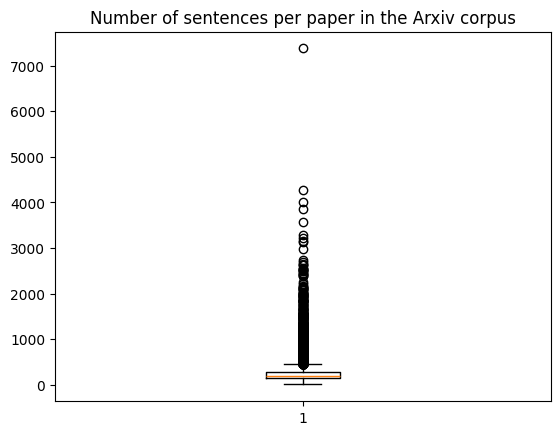

In [40]:
# boxplot of the number of sentences per paper in the corpus
sentences_per_paper = [len(p.content.sentence) for p in corpus_arxiv.papers]
plt.boxplot(sentences_per_paper)
plt.title("Number of sentences per paper in the Arxiv corpus")
plt.show()

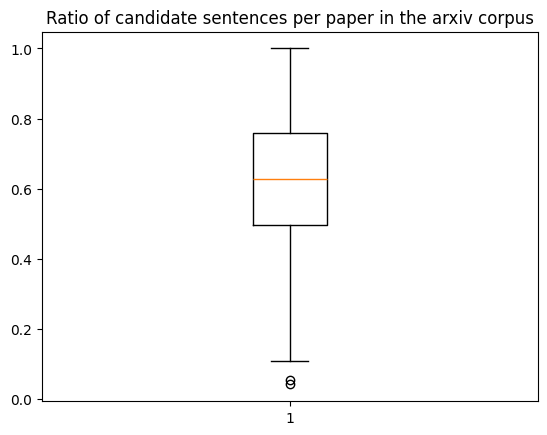

In [41]:
# boxplot of the ratio candidate sentences / total sentences per paper in the corpus
ratios = [p.content[p.content["candidate"] == True].shape[0] / len(p.content.sentence) for p in corpus_arxiv.papers]
plt.boxplot(ratios)
plt.title("Ratio of candidate sentences per paper in the arxiv corpus")
plt.show()

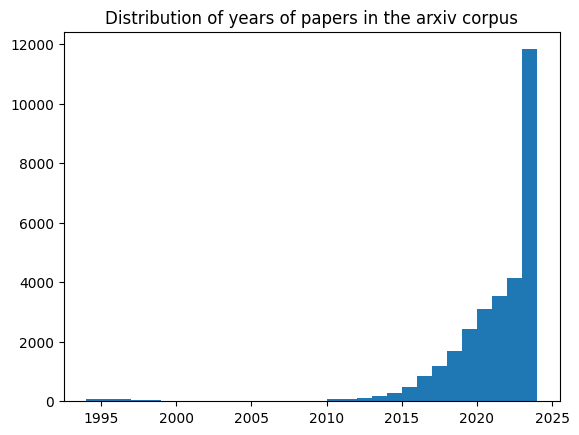

In [80]:
# distribution of dates
years = [p.year for p in corpus_arxiv.papers]
plt.hist(years, bins=range(min(years), max(years) + 1))
plt.title("Distribution of years of papers in the arxiv corpus")
plt.show()


In [85]:
# counts of articles per year
year_counts = Counter(years)
sorted(year_counts.items(), key = lambda x: x[0], reverse = True)

[(2024, 3618),
 (2023, 8213),
 (2022, 4142),
 (2021, 3538),
 (2020, 3097),
 (2019, 2425),
 (2018, 1701),
 (2017, 1172),
 (2016, 863),
 (2015, 465),
 (2014, 295),
 (2013, 165),
 (2012, 109),
 (2011, 72),
 (2010, 72),
 (2007, 4),
 (2006, 10),
 (2005, 5),
 (2004, 23),
 (2003, 17),
 (2002, 10),
 (2001, 14),
 (2000, 18),
 (1999, 17),
 (1998, 38),
 (1997, 45),
 (1996, 66),
 (1995, 84),
 (1994, 63)]

In [54]:
idx = df_errors[df_errors["error"].str.startswith("FileNotFoundError")]["id"].values
len(idx)

3471

In [55]:
for id in idx: 
    p = [p for p in corpus_arxiv.papers_with_errors if p.id == id][0]
    print(p.xml_path)
    break

None


In [77]:
df.head(10)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,pdf_stored,xml_stored
0,704.2083,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Introduction to Arabic Speech Recognition Usin...,"4 pages, 3 figures and 2 tables, was in Inform...",NaN,NaN,NaN,cs.CL cs.AI,NaN,In this paper Arabic was investigated from t...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[['Satori', 'H.', ''], ['Harti', 'M.', ''], ['...",True,False
1,704.2201,Hassan Satori,"H. Satori, M. Harti and N. Chenfour",Arabic Speech Recognition System using CMU-Sph...,"5 pages, 3 figures and 2 tables, in French",NaN,NaN,NaN,cs.CL cs.AI,NaN,In this paper we present the creation of an ...,"[{'version': 'v1', 'created': 'Tue, 17 Apr 200...",2007-05-23,"[['Satori', 'H.', ''], ['Harti', 'M.', ''], ['...",True,False
2,704.3665,Tian-Jian Jiang,"Mike Tian-Jian Jiang, Deng Liu, Meng-Juei Hsie...",On the Development of Text Input Method - Less...,10 pages,NaN,NaN,NaN,cs.CL cs.HC,NaN,Intelligent Input Methods (IM) are essential...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[['Jiang', 'Mike Tian-Jian', ''], ['Liu', 'Den...",True,False
3,704.3708,Bernat Corominas-Murtra BCM,Bernat Corominas-Murtra,Network statistics on early English Syntax: St...,"New abstract. Due to a mistake, abstract from ...",NaN,NaN,NaN,cs.CL,NaN,This paper includes a reflection on the role...,"[{'version': 'v1', 'created': 'Fri, 27 Apr 200...",2007-05-23,"[['Corominas-Murtra', 'Bernat', '']]",True,False
4,704.3886,W Saba,Walid S. Saba,A Note on Ontology and Ordinary Language,"19 pages, 1 figure",NaN,NaN,NaN,cs.AI cs.CL,NaN,We argue for a compositional semantics groun...,"[{'version': 'v1', 'created': 'Mon, 30 Apr 200...",2007-05-23,"[['Saba', 'Walid S.', '']]",True,False
5,705.0462,Nicolas Tabareau,"Paul-Andr\'e Melli\`es (PPS), Nicolas Tabareau...",Resource modalities in game semantics,NaN,NaN,NaN,NaN,math.CT cs.CL,NaN,The description of resources in game semanti...,"[{'version': 'v1', 'created': 'Thu, 3 May 2007...",2007-05-23,"[['Melliès', 'Paul-André', '', 'PPS'], ['Tabar...",True,False
6,705.1161,Lillian Lee,Lillian Lee,IDF revisited: A simple new derivation within ...,"To appear, Proceedings of SIGIR 2007, poster p...",NaN,NaN,NaN,cs.IR cs.CL,NaN,There have been a number of prior attempts t...,"[{'version': 'v1', 'created': 'Tue, 8 May 2007...",2007-05-23,"[['Lee', 'Lillian', '']]",True,False
7,707.0895,Damian H. Zanette,Damian H. Zanette,Segmentation and Context of Literary and Music...,To appear in Complex Systems,NaN,NaN,NaN,cs.CL physics.data-an,NaN,"We test a segmentation algorithm, based on t...","[{'version': 'v1', 'created': 'Fri, 6 Jul 2007...",2007-07-09,"[['Zanette', 'Damian H.', '']]",True,False
8,707.1913,Daniel Lemire,"Owen Kaser, Daniel Lemire",Removing Manually-Generated Boilerplate from E...,short version appeared in CASCON 2007 proceedi...,NaN,NaN,"Department of CSAS, UNBSJ Technical Report TR-...",cs.DL cs.CL,http://arxiv.org/licenses/nonexclusive-distrib...,Collaborative work on unstructured or semi-s...,"[{'version': 'v1', 'created': 'Fri, 13 Jul 200...",2016-08-24,"[['Kaser', 'Owen', ''], ['Lemire', 'Daniel', '']]",True,False
9,707.3559,Wilson Wong,Wilson Wong,Practical Approach to Knowledge-based Question...,"Master of Science thesis, National Technical U...",NaN,NaN,NaN,cs.CL cs.AI cs.HC cs.IR,NaN,This research hypothesized that a practical ...,"[{'version': 'v1', 'created': 'Tue, 24 Jul 200...",2007-07-25,"[['Wong', 'Wilson', '']]",True,False


In [74]:
with open("../data/arxiv/pdf_errors.txt", "r") as f:
    errors = f.readlines()

remaining_errors = []

for error in errors:
    id = error.split(", ")[0]
    if df[df["id"] == str(id)]["pdf_stored"].values == False:
        if error not in remaining_errors:
            remaining_errors.append(error)

print(len(remaining_errors))

with open("../data/arxiv/pdf_errors.txt", "w") as f:
    for error in remaining_errors:
        f.write(error)

3163


In [73]:
df[df["pdf_stored"] == False].shape

(3179, 16)

In [61]:
df[df["id"] == "704.3665"]["versions"].values

array(["[{'version': 'v1', 'created': 'Fri, 27 Apr 2007 05:58:32 GMT'}]"],
      dtype=object)

In [59]:
with open("../data/arxiv/pdf_errors.txt", "r") as f:
    pdf_errors = f.readlines()

for error in pdf_errors:
    print(error)

704.2083, failed: no PDF available 

704.2201, failed: no PDF available 

704.3665, failed: no PDF available 

704.3708, failed: no PDF available 

704.2083, failed: no PDF available 

0801.251, failed: no PDF available 

0805.103, failed: no PDF available 

0811.126, failed: no PDF available 

0812.307, failed: no PDF available 

0901.418, failed: no PDF available 

0905.113, failed: no PDF available 

0905.299, failed: no PDF available 

0907.496, failed: no PDF available 

0911.328, failed: no PDF available 

1008.017, failed: no PDF available 

1101.051, failed: no PDF available 

1102.218, failed: no PDF available 

1103.409, failed: no PDF available 

1108.385, failed: no PDF available 

1108.552, failed: no PDF available 

1110.147, failed: no PDF available 

1110.62, failed: no PDF available 

1111.719, failed: no PDF available 

1112.367, failed: no PDF available 

1204.014, failed: no PDF available 

1204.38, failed: no PDF available 

1206.201, failed: no PDF available 

120

## Same but for published arxiv papers
6039 papers which were initially left out from the corpus

In [36]:
corpus_arxiv_pub = utils.Corpus.Corpus(metadata_path = "../data/arxiv/arxiv-metadata-nlp-published.csv",
                      xml_dir_path= "../data/arxiv/tei.xml/",
                      name = "arXiv")

In [37]:
corpus_arxiv_pub.initialize(verbose = True)

Corpus 'arXiv' is being initialized...



100%|██████████| 6039/6039 [04:55<00:00, 20.40it/s]

Corpus 'arXiv' papers have been loaded.
Corpus 'arXiv' was filled with 6039 papers:
  - 0 papers were successfully loaded
  - 6039 papers could not be loaded

Preprocessing papers...


## C. Others

### Core claims

In [9]:
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

c:\Users\cleme\Documents\STAGE\data\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [57]:
import tqdm
p = corpus_ACL.papers[0]
s_embeddings = [model.encode(s) for s in p.content["sentence"].values]
#scores = []

In [58]:
for i, se1 in tqdm.tqdm(enumerate(s_embeddings)):
    if p.content.loc[i]["section"] != "abstract":
        continue
    s1 = p.content.iloc[i]["sentence"]
    print(f"{s1}")
    for j, se2 in enumerate(s_embeddings):
        if j > i and p.content.loc[j, "candidate"] == True:
            s2 = p.content.iloc[j]["sentence"]
            score = util.pytorch_cos_sim(se1, se2)
            if score > 0.6:
                print(f"---> {score.item()} : {s2}")
    print()

0it [00:00, ?it/s]

We present a series of studies of affirmative cue words-a family of cue words such as "okay" or "alright" that speakers use frequently in conversation.
---> 0.6065555810928345 : Examples of cue phrases include now, well, so, and, but, then, after all, furthermore, however, in consequence, as a matter of fact, in fact, actually, okay, alright, for example, and incidentally.
---> 0.8207764625549316 : In this study, we focus on a subclass of cue phrases that we term affirmative cue words (hereafter, ACWs), and that include alright, mm-hm, okay, right, and uh-huh, inter alia.
---> 0.6668821573257446 : Whereas ACWs thus form a subset of more general classes of utterances which have been studied in more general studies of cue words, cue phrases, discourse markers, feedback utterances, linguistic feedback, acknowledgments, grounding acts, our focus is on this particular subset of lexical items which may convey an affirmative response-but which may also convey many different meanings.
---> 0.6

1it [00:00,  4.50it/s]

---> 0.7070017457008362 : In summary, in this study we have identified a number of characterizations of affirmative cue words in a large corpus of SAE task-oriented dialogue.

These words pose a challenge for spoken dialogue systems because of their ambiguity: They may be used for agreeing with what the interlocutor has said, indicating continued attention, or for cueing the start of a new topic, among other meanings.
---> 0.7507622838020325 : These words are frequent in spontaneous conversation, especially in task-oriented dialogue, and are heavily overloaded: Their possible discourse/pragmatic functions include agreeing with what the interlocutor has said, displaying interest and continued attention, and cueing the start of a new topic.
---> 0.6897234320640564 : The disambiguation of these meanings we believe is critical to the success of spoken dialogue systems.


2it [00:00,  3.84it/s]

---> 0.60649174451828 : Considering the high frequency of ACWs in task-oriented dialogue, it is critical for some spoken language processing applications such as spoken dialogue systems to model the usage of these words correctly, from both an understanding and a generation perspective.

We describe differences in the acoustic/prosodic realization of such functions in a corpus of spontaneous, task-oriented dialogues in Standard American English.
---> 0.653379499912262 : Section 4 presents a statistical description of the acoustic, prosodic, and contextual characteristics of the functions of ACWs in this corpus.
---> 0.6250091195106506 : Novick and Sutton (1994) propose an alternative categorization of linguistic feedback in task-oriented dialogue, which is based on the structural context of exchanges rather than on the characteristics of the preceding utterance.
---> 0.6316356658935547 : Recently, Gravano and Hirschberg (2009a, 2009b, 2011) describe six distinct prosodic, acoustic, and

3it [00:01,  2.46it/s]

---> 0.6159815788269043 : The comparison of these numeric acoustic features across discourse/pragmatic functions confirms that the observations made previously for categorical prosodic features also hold when considering numeric features such as pitch slope, thus making the likelihood that such observations will be of practical use in actual systems.
---> 0.6037591695785522 : The experiments are conducted on transcripts of 1,368 utterances from 14 dialogues in English.
---> 0.607715904712677 : In the study of automatic classification of ACWs presented in Section 5 we show that for spoken task-oriented dialogue, the simple discourse/sentential distinction is insufficient.

These results are important both for interpretation and for production in spoken language applications.
---> 0.7787131071090698 : This kind of characterization is important both for interpretation and for production in spoken language applications: If we can find reliable features that effectively distinguish the vari

5it [00:01,  4.08it/s]


We also assess the predictive power of computational methods for the automatic disambiguation of these words.
---> 0.6079588532447815 : The corpus on which our experiments were conducted, rich in ACWs conveying a wide range of discourse/pragmatic functions, has allowed us to systematically investigate many dimensions of these words, including their production and automatic disambiguation.

We find that contextual information and final intonation figure as the most salient cues to automatic disambiguation.


497it [00:01, 300.78it/s]

In [59]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
for i, s1 in enumerate(p.content["sentence"].values):
    if p.content.loc[i]["section"] != "abstract":
        continue
    print(f"{s1}")
    for j, s2 in enumerate(p.content["sentence"].values):
        if j > i and p.content.loc[j, "candidate"] == True:
            r_scores = scorer.score(s1, s2)
            if r_scores["rouge1"].fmeasure > 0.4:
                print(f"---> {r_scores['rouge1'].fmeasure} : {s2}")
    print()

We present a series of studies of affirmative cue words-a family of cue words such as "okay" or "alright" that speakers use frequently in conversation.
---> 0.41379310344827586 : In this study, we focus on a subclass of cue phrases that we term affirmative cue words (hereafter, ACWs), and that include alright, mm-hm, okay, right, and uh-huh, inter alia.
---> 0.4242424242424242 : Also, in a study of the function of intonation in Scottish English task-oriented dialogue, Kowtko (1996) examines a corpus of 273 instances of single-word utterances, including affirmative cue words such as mmhm, okay, right, uh-huh, and yes.
---> 0.45 : In this work we have undertaken a comprehensive study of affirmative cue words, a subset of cue phrases such as okay, yeah, or alright that may be utilized to convey as many as ten different discourse/pragmatic functions, such as indicating continued attention to the interlocutor or cueing the beginning of a new topic.
---> 0.4313725490196078 : In summary, in t

(array([ 12.,  33.,  52.,  82., 117., 108., 120., 118.,  96.,  86.,  59.,
         45.,  36.,  27.,  10.,  11.,   3.,   2.,   2.,   3.]),
 array([-0.06328004, -0.02201925,  0.01924153,  0.06050231,  0.1017631 ,
         0.14302388,  0.18428467,  0.22554545,  0.26680624,  0.30806702,
         0.34932781,  0.39058859,  0.43184938,  0.47311016,  0.51437094,
         0.55563173,  0.59689251,  0.6381533 ,  0.67941408,  0.72067487,
         0.76193565]),
 <BarContainer object of 20 artists>)

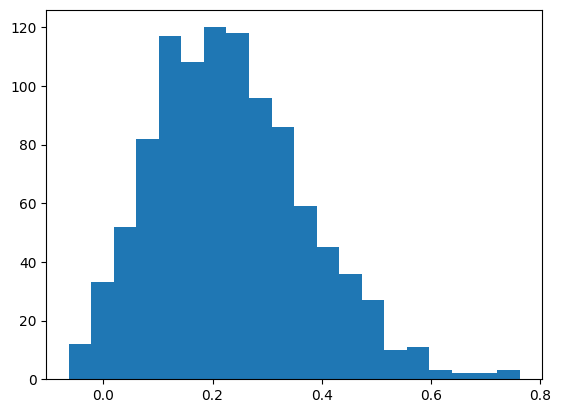

In [39]:
scores = sorted(scores, key = lambda x: x[2], reverse = True)
plt.hist([s[2] for s in scores], bins = 20)

In [40]:
import numpy as np
for score in np.arange(1.0, 0.5, -0.05):
    print(f"---Between {score} and {score - 0.05}")
    _ = [print(s[0], "\n", s[1], "\n", s[2]) for s in scores if s[2] > score and s[2] < score + 0.05]
    print()

---Between 1.0 and 0.95

---Between 0.95 and 0.8999999999999999

---Between 0.8999999999999999 and 0.8499999999999999

---Between 0.8499999999999999 and 0.7999999999999998

---Between 0.7999999999999998 and 0.7499999999999998

---Between 0.7499999999999998 and 0.6999999999999997
The proposed LM can be expanded to new domains by adding about 2% of parameters for a first domain and 13% parameters for after second domain. 
 The proposed architecture allows LMs to expand multi-domain, suppressing the increase of the number of parameters. 
 0.7619356513023376
  We propose an adapter based multi-domain Transformer based language model (LM) for Transformer ASR. 
 In this paper, we study an external LM structure for Transformer based ASR model that can be adapted for multi-domain with only 2% or 13% parameter addition per domain. 
 0.7546730637550354
The proposed model can reuse the full fine-tuned LM which is fine-tuned using all layers of an original model. 
 Finally, the proposed architectu

In [42]:
cos_sim_scores = []
for a_s in abs_sentences:
    embedding_1= model.encode(a_s, convert_to_tensor=True)
    for i, na_s in enumerate(non_abs_sentences):
        embedding_2 = model.encode(na_s, convert_to_tensor=True)
        cos_sim = util.pytorch_cos_sim(embedding_1, embedding_2)
        cos_sim_scores.append((cos_sim, a_s, na_s))

cos_sim_scores = sorted(cos_sim_scores, key = lambda x: x[0], reverse = True)
for top_sim in cos_sim_scores[:5]:
    print(top_sim[0])
    print(top_sim[1])
    print(top_sim[2])
    print()

tensor([[0.8875]])
  The long-standing one-to-many issue of the open-domain dialogues poses significant challenges for automatic evaluation methods, i.e., there may be multiple suitable responses which differ in semantics for a given conversational context.
In addition, we provide a detailed analysis of the effectiveness of our proposed method in solving the one-to-many issue in open-domain dialogue evaluation.

tensor([[0.8517]])
  The long-standing one-to-many issue of the open-domain dialogues poses significant challenges for automatic evaluation methods, i.e., there may be multiple suitable responses which differ in semantics for a given conversational context.
To tackle the one-to-many issue, we design a reference-based automatic evaluation metric (CMN), which can robustly evaluate open-domain dialogues with a single gold-standard reference.

tensor([[0.8243]])
Experimental results on two open-domain dialogue datasets demonstrate the superiority of our method compared with a wide 

### Selection of some papers for annotation (doccano)

Initial selection:

In [18]:
# select 5 random papers in acl and 5 random papers in arxiv
import random
# random seed for reproducibility
random.seed(23)
random_acl = random.sample(corpus_ACL.papers, 5)
random_arxiv = random.sample(corpus_arxiv.papers, 5)

random_list = random_acl + random_arxiv

# shuffle the list
random.shuffle(random_list)

data = []

for rp in random_list:
    contents = rp.content[["sentence", "section", "id", "candidate"]].values
    for i, row in enumerate(contents):
        if row[3] == True:
            # catch the previous sentence
            if i == 0:
                prev_sec, prev_sent = None, None
            else:
                prev_sec, prev_sent = contents[i-1][1], contents[i-1][0]

            # current sentence (the one to annotate)
            sec, sent = row[1], row[0]

            # catch the next sentence
            if i == len(contents) - 1:
                next_sec, next_sent = None, None
            else:
                next_sec, next_sent = contents[i+1][1], contents[i+1][0]

            data.append({"article_id": rp.id, "source": rp.corpus.name, "sent_id": row[2], "prev_sec": prev_sec, "prev_sent": prev_sent, "sec": sec, "sent": sent, "next_sec": next_sec, "next_sent": next_sent})


In [19]:
import pandas as pd
df_anno = pd.DataFrame(data)
df_anno

,article_id,source,sent_id,prev_sec,prev_sent,sec,sent,next_sec,next_sent
0,W19-4322,ACL,0,None,None,abstract,Short text clustering is a challenging problem...,abstract,Lowdimensional continuous representations or e...
1,W19-4322,ACL,1,abstract,Short text clustering is a challenging problem...,abstract,Lowdimensional continuous representations or e...,abstract,While deep clustering has been studied extensi...
2,W19-4322,ACL,2,abstract,Lowdimensional continuous representations or e...,abstract,While deep clustering has been studied extensi...,abstract,"The method we propose, learns discriminative f..."
3,W19-4322,ACL,3,abstract,While deep clustering has been studied extensi...,abstract,"The method we propose, learns discriminative f...",abstract,Experiments on three short text datasets empir...
4,W19-4322,ACL,4,abstract,"The method we propose, learns discriminative f...",abstract,Experiments on three short text datasets empir...,Introduction,Text clustering groups semantically similar te...
...,...,...,...,...,...,...,...,...,...
1428,1407.6853,arXiv,162,Named Entity Recognition,"In the second column, the state-of-the-art res...",Named Entity Recognition,"In the third column, the parser using the SCOD...",Conclusion,We analyzed SCODE word embeddings in supervise...
1429,1407.6853,arXiv,163,Named Entity Recognition,"In the third column, the parser using the SCOD...",Conclusion,We analyzed SCODE word embeddings in supervise...,Conclusion,SCODE word embeddings are previously used in u...
1430,1407.6853,arXiv,164,Conclusion,We analyzed SCODE word embeddings in supervise...,Conclusion,SCODE word embeddings are previously used in u...,Conclusion,Their first use in a supervised setting was in...
1431,1407.6853,arXiv,165,Conclusion,SCODE word embeddings are previously used in u...,Conclusion,Their first use in a supervised setting was in...,Conclusion,(Lei et al.2014) successfully make use of SCOD...


For arxiv papers, we'll redraw some articles to avoid them being part of the ACL Antho / being too recent.

In [23]:
# df_anno.to_csv("claims-to-annotate-10-papers.csv", index = False)

In [26]:
df_anno = pd.read_csv("claims-to-annotate-10-papers.csv")
df_anno = df_anno[df_anno["source"] == "ACL"]
random_acl = df_anno.article_id.unique()
print(random_acl)

['W17-4709' 'P18-1048' 'Y15-1047' 'N19-1358' '2020.signlang-1.20']


In [40]:
unpublished_NLP = pd.read_csv("arxiv-metadata-nlp-unpublished.csv")
unpublished_NLP["update_year"] = unpublished_NLP["update_date"].apply(lambda x: x[:4])
unpublished_NLP["update_year"] = unpublished_NLP["update_year"].astype(int)
unpublished_NLP["update_year"].value_counts()

2023    8868
2024    5198
2022    4439
2021    3906
2020    3332
2019    2480
2018    1821
2017    1247
2016     922
2015     468
2014     291
2008     238
2007     190
2013     161
2012     124
2011      46
2009      46
2010      40
Name: update_year, dtype: int64

In [41]:
unpublished_NLP_upto2022 = unpublished_NLP[unpublished_NLP["update_year"]<2023]
arxiv_df = pd.read_csv("arxiv-metadata-nlp-unpublished-sample-1000.csv")
arxiv_df = arxiv_df[arxiv_df["id"].isin(set(unpublished_NLP_upto2022.id.values))]
print(arxiv_df.shape)

(511, 14)


In [55]:
import random
random.seed(23)
random_arxiv = random.sample(list(arxiv_df["id"]), 5)
print(random_arxiv)

random_idx = random_arxiv + list(random_acl)
random.shuffle(random_idx)
print(random_idx)

data = []
for idx in random_idx:
    if idx in random_arxiv:
        p = corpus_arxiv.get_paper_by_id(idx)

        contents = p.content[["sentence", "section", "id", "candidate"]].values
        for i, row in enumerate(contents):
            if row[3] == True:
                # catch the previous sentence
                if i == 0:
                    prev_sec, prev_sent = None, None
                else:
                    prev_sec, prev_sent = contents[i-1][1], contents[i-1][0]

                # current sentence (the one to annotate)
                sec, sent = row[1], row[0]

                # catch the next sentence
                if i == len(contents) - 1:
                    next_sec, next_sent = None, None
                else:
                    next_sec, next_sent = contents[i+1][1], contents[i+1][0]

                data.append({"article-title": p.title, "article_id": p.id, "source": p.corpus.name, "sent_id": row[2], "prev_sec": prev_sec, "prev_sent": prev_sent, "sec": sec, "sent": sent, "next_sec": next_sec, "next_sent": next_sent})

    else:
        rows = df_anno[df_anno["article_id"] == idx]
        for i, row in rows.iterrows():
            data.append({"article-title": "", "article_id": row["article_id"], "source": "ACL", "sent_id": row["sent_id"], "prev_sec": row["prev_sec"], "prev_sent": row["prev_sent"], "sec": row["sec"], "sent": row["sent"], "next_sec": row["next_sec"], "next_sent": row["next_sent"]})


['1605.05172', '2012.04584', '2103.14302', '1708.01009', '1611.08765']
['2020.signlang-1.20', 'W17-4709', 'N19-1358', '2103.14302', 'Y15-1047', 'P18-1048', '1708.01009', '1611.08765', '1605.05172', '2012.04584']


In [56]:
df = pd.DataFrame(data)
df

,article-title,article_id,source,sent_id,prev_sec,prev_sent,sec,sent,next_sec,next_sent
0,,2020.signlang-1.20,ACL,0,NaN,NaN,abstract,In this paper we report on a research effort f...,abstract,Three sequential models have been developed fo...
1,,2020.signlang-1.20,ACL,1,abstract,In this paper we report on a research effort f...,abstract,Three sequential models have been developed fo...,abstract,The models have been applied to a Danish and a...
2,,2020.signlang-1.20,ACL,2,abstract,Three sequential models have been developed fo...,abstract,The models have been applied to a Danish and a...,abstract,"Moreover, during the reported research, a meth..."
3,,2020.signlang-1.20,ACL,3,abstract,The models have been applied to a Danish and a...,abstract,"Moreover, during the reported research, a meth...",Introduction,One of the problems relating to sign language ...
4,,2020.signlang-1.20,ACL,4,abstract,"Moreover, during the reported research, a meth...",Introduction,One of the problems relating to sign language ...,Introduction,"Therefore, most data collections contain a ver..."
...,...,...,...,...,...,...,...,...,...,...
982,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,230,CONCLUSION,"In this paper, we introduce a method to train ...",CONCLUSION,Our approach is inspired by knowledge distilla...,CONCLUSION,"In particular, we use the cross-attention scor..."
983,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,231,CONCLUSION,Our approach is inspired by knowledge distilla...,CONCLUSION,"In particular, we use the cross-attention scor...",CONCLUSION,We compare different ways to aggregate the sco...
984,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,232,CONCLUSION,"In particular, we use the cross-attention scor...",CONCLUSION,We compare different ways to aggregate the sco...,CONCLUSION,We show that iteratively training the reader a...
985,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,233,CONCLUSION,We compare different ways to aggregate the sco...,CONCLUSION,We show that iteratively training the reader a...,CONCLUSION,"In the future, we would like to explore better..."


In [57]:
df_acl = pd.read_pickle("acl-metadata-sample-1000.pkl")
id2titles = {}
for idx in random_acl:
    id2titles[idx] = df_acl[df_acl["acl_id"] == idx].title.values[0]

id2titles

{'W17-4709': 'Tree as a Pivot: Syntactic Matching Methods in Pivot Translation',
 'P18-1048': 'Self-regulation: Employing a Generative Adversarial Network to Improve Event Detection',
 'Y15-1047': 'Not Voice but Case Identity in {VP} Ellipsis of {E}nglish',
 'N19-1358': 'Playing Text-Adventure Games with Graph-Based Deep Reinforcement Learning',
 '2020.signlang-1.20': 'Recognition of Static Features in Sign Language Using Key-Points'}

In [58]:
for idx in random_acl:
    # assign the title
    df.loc[df["article_id"] == idx, "article-title"] = id2titles[idx]
df.value_counts("article-title")

article-title
Not Voice but Case Identity in {VP} Ellipsis of {E}nglish                                     183
Fill it up: Exploiting partial dependency annotations in a minimum\n  spanning tree parser    141
Self-regulation: Employing a Generative Adversarial Network to Improve Event Detection        136
Playing Text-Adventure Games with Graph-Based Deep Reinforcement Learning                     112
Siamese convolutional networks based on phonetic features for cognate\n  identification       103
Tree as a Pivot: Syntactic Matching Methods in Pivot Translation                               92
Revisiting Activation Regularization for Language RNNs                                         76
Distilling Knowledge from Reader to Retriever for Question Answering                           66
Mutually-Constrained Monotonic Multihead Attention for Online ASR                              61
Recognition of Static Features in Sign Language Using Key-Points                               17
dtype:

In [60]:
df.head()

,article-title,article_id,source,sent_id,prev_sec,prev_sent,sec,sent,next_sec,next_sent
0,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,0,NaN,NaN,abstract,In this paper we report on a research effort f...,abstract,Three sequential models have been developed fo...
1,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,1,abstract,In this paper we report on a research effort f...,abstract,Three sequential models have been developed fo...,abstract,The models have been applied to a Danish and a...
2,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,2,abstract,Three sequential models have been developed fo...,abstract,The models have been applied to a Danish and a...,abstract,"Moreover, during the reported research, a meth..."
3,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,3,abstract,The models have been applied to a Danish and a...,abstract,"Moreover, during the reported research, a meth...",Introduction,One of the problems relating to sign language ...
4,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,4,abstract,"Moreover, during the reported research, a meth...",Introduction,One of the problems relating to sign language ...,Introduction,"Therefore, most data collections contain a ver..."


In [70]:
doccano_id2article_id = {i:idx for i, idx in enumerate(random_idx)}
article_id2doccano_id = {idx:i for i, idx in enumerate(random_idx)}

In [78]:
df["article_id-d"] = df["article_id"].apply(lambda x: article_id2doccano_id[x])
df

,article-title,article_id,source,sent_id,prev_sec,prev_sent,sec,sent,next_sec,next_sent,article_id-d
0,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,0,NaN,NaN,abstract,In this paper we report on a research effort f...,abstract,Three sequential models have been developed fo...,0
1,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,1,abstract,In this paper we report on a research effort f...,abstract,Three sequential models have been developed fo...,abstract,The models have been applied to a Danish and a...,0
2,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,2,abstract,Three sequential models have been developed fo...,abstract,The models have been applied to a Danish and a...,abstract,"Moreover, during the reported research, a meth...",0
3,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,3,abstract,The models have been applied to a Danish and a...,abstract,"Moreover, during the reported research, a meth...",Introduction,One of the problems relating to sign language ...,0
4,Recognition of Static Features in Sign Languag...,2020.signlang-1.20,ACL,4,abstract,"Moreover, during the reported research, a meth...",Introduction,One of the problems relating to sign language ...,Introduction,"Therefore, most data collections contain a ver...",0
...,...,...,...,...,...,...,...,...,...,...,...
982,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,230,CONCLUSION,"In this paper, we introduce a method to train ...",CONCLUSION,Our approach is inspired by knowledge distilla...,CONCLUSION,"In particular, we use the cross-attention scor...",9
983,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,231,CONCLUSION,Our approach is inspired by knowledge distilla...,CONCLUSION,"In particular, we use the cross-attention scor...",CONCLUSION,We compare different ways to aggregate the sco...,9
984,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,232,CONCLUSION,"In particular, we use the cross-attention scor...",CONCLUSION,We compare different ways to aggregate the sco...,CONCLUSION,We show that iteratively training the reader a...,9
985,Distilling Knowledge from Reader to Retriever ...,2012.04584,arXiv,233,CONCLUSION,We compare different ways to aggregate the sco...,CONCLUSION,We show that iteratively training the reader a...,CONCLUSION,"In the future, we would like to explore better...",9


In [80]:
df.to_csv("claims-to-annotate-10-papers-fulldoc.csv", index = False)
df = pd.read_csv("claims-to-annotate-10-papers-fulldoc.csv")

In [73]:
# save doccano_id2article_id as a json file
import json
with open("doccano_id2article_id-10-article.json", "w") as f:
    json.dump(doccano_id2article_id, f)

In [89]:
df_anno = df[["article_id-d", "sent_id", "sent", "sec", "prev_sec", "prev_sent", "next_sec", "next_sent"]]
df_anno["label"] = [""] * df_anno.shape[0]
df_anno = df_anno.rename(columns = {"article_id-d": "doccano_art_id", "sent_id": "sentence_id", "sent": "sentence", "sec": "current_sentence_section", "prev_sec": "previous_sentence_section", "prev_sent": "previous_sentence", "next_sec": "next_sentence_section", "next_sent": "next_sentence"})
df_anno.to_csv("claims-to-annotate-10-papers-partialdoc.csv")

C:\Users\cleme\AppData\Local\Temp\ipykernel_11684\2342835808.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anno["label"] = [""] * df_anno.shape[0]


In [90]:
df_anno

,doccano_art_id,sentence_id,sentence,current_sentence_section,previous_sentence_section,previous_sentence,next_sentence_section,next_sentence,label
0,0,0,In this paper we report on a research effort f...,abstract,NaN,NaN,abstract,Three sequential models have been developed fo...,
1,0,1,Three sequential models have been developed fo...,abstract,abstract,In this paper we report on a research effort f...,abstract,The models have been applied to a Danish and a...,
2,0,2,The models have been applied to a Danish and a...,abstract,abstract,Three sequential models have been developed fo...,abstract,"Moreover, during the reported research, a meth...",
3,0,3,"Moreover, during the reported research, a meth...",abstract,abstract,The models have been applied to a Danish and a...,Introduction,One of the problems relating to sign language ...,
4,0,4,One of the problems relating to sign language ...,Introduction,abstract,"Moreover, during the reported research, a meth...",Introduction,"Therefore, most data collections contain a ver...",
...,...,...,...,...,...,...,...,...,...
982,9,230,Our approach is inspired by knowledge distilla...,CONCLUSION,CONCLUSION,"In this paper, we introduce a method to train ...",CONCLUSION,"In particular, we use the cross-attention scor...",
983,9,231,"In particular, we use the cross-attention scor...",CONCLUSION,CONCLUSION,Our approach is inspired by knowledge distilla...,CONCLUSION,We compare different ways to aggregate the sco...,
984,9,232,We compare different ways to aggregate the sco...,CONCLUSION,CONCLUSION,"In particular, we use the cross-attention scor...",CONCLUSION,We show that iteratively training the reader a...,
985,9,233,We show that iteratively training the reader a...,CONCLUSION,CONCLUSION,We compare different ways to aggregate the sco...,CONCLUSION,"In the future, we would like to explore better...",


In [96]:
random_idx

['2020.signlang-1.20',
 'W17-4709',
 'N19-1358',
 '2103.14302',
 'Y15-1047',
 'P18-1048',
 '1708.01009',
 '1611.08765',
 '1605.05172',
 '2012.04584']

In [97]:
for idx in random_idx:
    source = "arXiv" if idx in random_arxiv else "ACL"
    print(idx, source)

2020.signlang-1.20 ACL
W17-4709 ACL
N19-1358 ACL
2103.14302 arXiv
Y15-1047 ACL
P18-1048 ACL
1708.01009 arXiv
1611.08765 arXiv
1605.05172 arXiv
2012.04584 arXiv


In [104]:
reduced_list = ["2020.signlang-1.20", "W17-4709", "2103.14302", "1708.01009"]
red_doccano = [article_id2doccano_id[idx] for idx in reduced_list]
print(red_doccano)

red_df = df[df["article_id"].isin(reduced_list)]
red_df.to_csv("claims-to-annotate-4-papers-fulldoc.csv", index = False)

red_df_anno = df_anno[df_anno["doccano_art_id"].isin(red_doccano)]
red_df_anno.to_csv("claims-to-annotate-4-papers-partialdoc.csv", index = False)

[0, 1, 3, 6]


In [106]:
red_df_anno.doccano_art_id.unique()

array([0, 1, 3, 6], dtype=int64)